In [1]:
import chess
from stockfish import Stockfish
stockfish = Stockfish(path=r"Z:\Chess\stockfish\stockfish-windows-x86-64-avx2.exe")
import random
from pprint import pprint
import numpy as np
import os
import glob
import time
import uuid

In [2]:
#test checkmate:
board = chess.Board()
board.push_san("e4")
board.push_san("e5")
board.push_san("Qh5")
board.push_san("Nc6")
board.push_san("Bc4")
board.push_san("Nf6")
board.push_san("Qxf7")
board.is_checkmate()
# board

True

In [3]:
#stockfish intro

#set pos from starting pos
# stockfish.set_position(["e2e4", "e7e6"])

#set pos from current pos:
# stockfish.make_moves_from_current_position(["g4d7", "a8b8", "f1d1"])

#get best move 
stockfish.get_best_move()

# Get best move based on a time constraint
# stockfish.get_best_move_time(1000)

#get current board position with FEN encoding
stockfish.get_fen_position()

#reset board position:
#-> dont need this since we just add to moves


'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

In [5]:
#print chess board from fen position: 
fen = "r1b2rk1/pp2ppbp/1nP2np1/q2PN3/8/2N3P1/PP2PPBP/R1BQK2R b KQ - 2 10"
def fen_to_board(fen):
    board = []
    for row in fen.split('/'):
        brow = []
        for c in row:
            if c == ' ':
                break
            elif c in '12345678':
                brow.extend( ['--'] * int(c) )
            elif c == 'p':
                brow.append( 'bp' )
            elif c == 'P':
                brow.append( 'wp' )
            elif c > 'Z':
                brow.append( 'b'+c.upper() )
            else:
                brow.append( 'w'+c )

        board.append( brow )
    return board

print( fen_to_board(fen) )

[['bR', '--', 'bB', '--', '--', 'bR', 'bK', '--'], ['bp', 'bp', '--', '--', 'bp', 'bp', 'bB', 'bp'], ['--', 'bN', 'wp', '--', '--', 'bN', 'bp', '--'], ['bQ', '--', '--', 'wp', 'wN', '--', '--', '--'], ['--', '--', '--', '--', '--', '--', '--', '--'], ['--', '--', 'wN', '--', '--', '--', 'wp', '--'], ['wp', 'wp', '--', '--', 'wp', 'wp', 'wB', 'wp'], ['wR', '--', 'wB', 'wQ', 'wK', '--', '--', 'wR']]


In [ ]:
#helper functions:
def checkEndCondition(board):
	if (board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.can_claim_threefold_repetition() or board.can_claim_fifty_moves() or board.can_claim_draw()):
		return True
	return False


def saveData(moves, positions):
	#Save best moves and positions to npy file so they can be used for training later
	moves = np.array(moves).reshape(-1, 1)
	positions = np.array(positions).reshape(-1,1)
	movesAndPositions = np.concatenate((moves, positions), axis = 1)

	nextUuid = uuid.uuid4()
	np.save(f"../data/rawData/movesAndPositions{nextUuid}.npy", movesAndPositions)
	print(f"Saved successfully as ../data/rawData/movesAndPositions{nextUuid}.npy")


def runGame(numMoves, index = 0):
	"""run a game you stored"""
	raw_data_dir = "../data/rawData"
	filesByLastmod = sorted(filter(os.path.isfile, glob.glob(raw_data_dir + '/*.npy')), key = os.path.getmtime)
	filename = filesByLastmod[index]
	testing = np.load(filename)
	moves = testing[:, 0]
	if (numMoves > len(moves)):
		print("Must enter a lower number of moves than maximum game length. Game length here is: ", len(moves))
		return

	testBoard = chess.Board()

	for i in range(numMoves):
		move = moves[i]
		testBoard.push_san(move)

	print(filename)
	return testBoard


#save
def findNextIdx():
	files = (glob.glob(r"../data/rawData/*.npy"))
	if (len(files) == 0):
		return 1 #if no files, return 1
	highestIdx = 0
	for f in files:
		file = f
		currIdx = file.split("movesAndPositions")[-1].split(".npy")[0]
		highestIdx = max(highestIdx, int(currIdx))

	return int(highestIdx)+1


In [25]:
def mineGames(numGames : int):
	"""mines numGames games of moves"""
	MAX_MOVES = 500 #don't continue games after this number

	for i in range(numGames):
		#Reset to starting positions
		currentGameMoves = []
		currentGamePositions = []
		board = chess.Board()
		stockfish.set_position([])

		for i in range(MAX_MOVES):
			#randomly choose from those 3 moves
			moves = stockfish.get_top_moves(3)
			#if less than 3 moves available, choose first one, if none available, exit
			if (len(moves) == 0):
				print("game is over")
				break
			elif (len(moves) == 1):
				move = moves[0]["Move"]
			elif (len(moves) == 2):
				#We dont always choose best move to add variety and keep selection more stochastic
				move = random.choices(moves, weights=(80, 20), k=1)[0]["Move"] #80% chance best move, 20% chance 2nd best
			else:
				move = random.choices(moves, weights=(80, 15, 5), k=1)[0]["Move"]#80% best, 15% 2nd best, 5% 3rd best

			currentGamePositions.append(stockfish.get_fen_position())
			currentGameMoves.append(move) #make sure to add str version of move before changing format
			move = chess.Move.from_uci(str(move)) #convert to format chess package likes
			board.push(move)
			stockfish.set_position(currentGameMoves)
			if (checkEndCondition(board)):
				print("game is over because end condition met")
				break
		saveData(currentGameMoves, currentGamePositions)
	

mineGames(100)

	

game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositionsf5073e4f-b46b-4be4-a79d-f60944e9ec6b.npy
game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositions1c59ce8c-cd33-46d1-95ad-5282cee20862.npy
game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositions280286a0-4688-464b-8c22-9cdbba811830.npy
game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositionsb36ddbcd-dfc4-4cc0-8465-d55eef91baf8.npy
game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositions90d42149-3688-486f-bee0-8d3fe03515ec.npy
game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositionse0ca51ae-dfe5-4528-8684-147c1217969b.npy
game is over because end condition met
Saved successfully as ../data/rawData/movesAndPositions7df6352a-ec27-4229-896a-66b555a4bb2b.npy
game is over because end condition met
Saved successful

KeyboardInterrupt: 

In [ ]:
#TODO try to parallelize game simulation to speed up data collection
#TODO add more randomness to move selection to get more varied data

File 0: ../data/rawData\movesAndPositions2b6e8e98-7bde-4360-a15c-2ff3d376792b.npy with 109 moves
File 1: ../data/rawData\movesAndPositions7f7e202a-b2c8-4477-a02e-54d7fc2373ba.npy with 122 moves
File 2: ../data/rawData\movesAndPositions960349b2-085f-4058-ba64-fb3da27d5f1d.npy with 100 moves
../data/rawdata\movesAndPositions2b6e8e98-7bde-4360-a15c-2ff3d376792b.npy


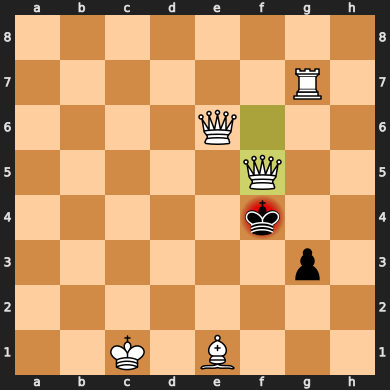

In [ ]:
#open a game and play it

#MS Begin
#Get number of moves in each file
files = (glob.glob(r"../data/rawData/*.npy"))
for index in range(len(files)):
  raw_data_dir = "../data/rawData"
  filesByLastmod = sorted(filter(os.path.isfile, glob.glob(raw_data_dir + '/*.npy')), key = os.path.getmtime)
  filename = filesByLastmod[index]
  testing = np.load(filename)
  moves = testing[:, 0]
  print(f"File {index}: {filename} with {len(moves)} moves")
#MS End

testBoard = runGame(109, 0)
testBoard
